In [1]:
import numpy as np
import random as rn
rn.seed(0)
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scanpy.external as sce

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy.sparse import csr_matrix

mtx = pd.read_csv('./data/GSE112013_Combined_UMI_table.txt.gz',sep='\t',index_col=0,engine='c')
barcodes = mtx.columns
genes = mtx.index
mtx = csr_matrix(mtx.values.T)
mtx.eliminate_zeros()
mtx.shape

(6490, 27477)

In [3]:
adata = sc.AnnData(mtx)
adata.obs_names = barcodes
adata.var_names = genes
adata.obs['Donor'] = adata.obs.index.map(lambda s: s.split('-')[0])

sc.pp.filter_genes(adata, min_cells=5)

sc.pp.normalize_total(adata)

adata.raw = adata

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata,n_top_genes=5000)

adata

AnnData object with n_obs × n_vars = 6490 × 26266
    obs: 'Donor'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [4]:
sc.tl.pca(adata,use_highly_variable=True)
sce.pp.bbknn(adata,batch_key='Donor')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=1.0)

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# markers I used, from https://www.nature.com/articles/s41422-018-0099-2.pdf
# myoid: ACTA2
# sertoli: SOX9
# leydig: DLK1
# endothelial: VWF
# late primary: SPO11
# round: SPAG6
# elongated: CREM

cell_types = {
    '11': 'myoid cells',
    '19': 'sertoli cells',
    '0': 'leydig cells',
    '7': 'endothelial cells',
    '8': 'macrophages',
    '13': 'spermatogonial stem cells',
    '9': 'differentiating spermatogonia',
    '9': 'early primary spermatocytes',
    '15': 'early primary spermatocytes',
    '10': 'late primary spermatocytes',
    '17': 'late primary spermatocytes',
    '16': 'round spermatids',
    '18': 'round spermatids',
    '3': 'elongated spermatids',
    '6': 'elongated spermatids',
    '12':'sperm cells',
    '2':'sperm cells',
    '5':'sperm cells',
    '1':'sperm cells',
    '4':'sperm cells',
    '20':'sperm cells',
    '14':'sperm cells',
}

# adata.obs['cell_type'] = adata.obs['leiden'].astype(str).map(cell_types)
# adata.obs['cell_type'].to_csv('./data/testis_cell_types.csv')

# Leiden clustering was not reproducing across runs...
adata.obs = pd.read_csv('./data/testis_cell_types.csv',index_col=0)

... storing 'leiden' as categorical
... storing 'Ghoshal_types' as categorical


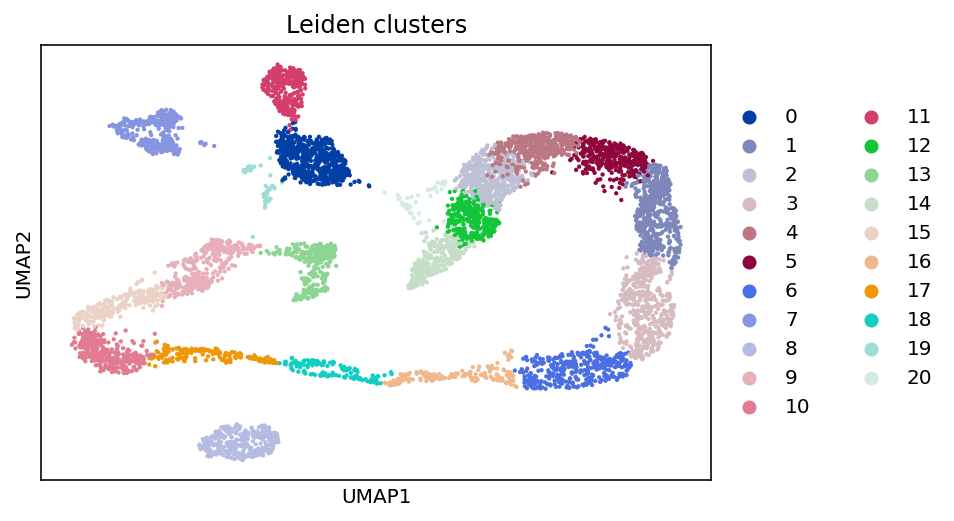

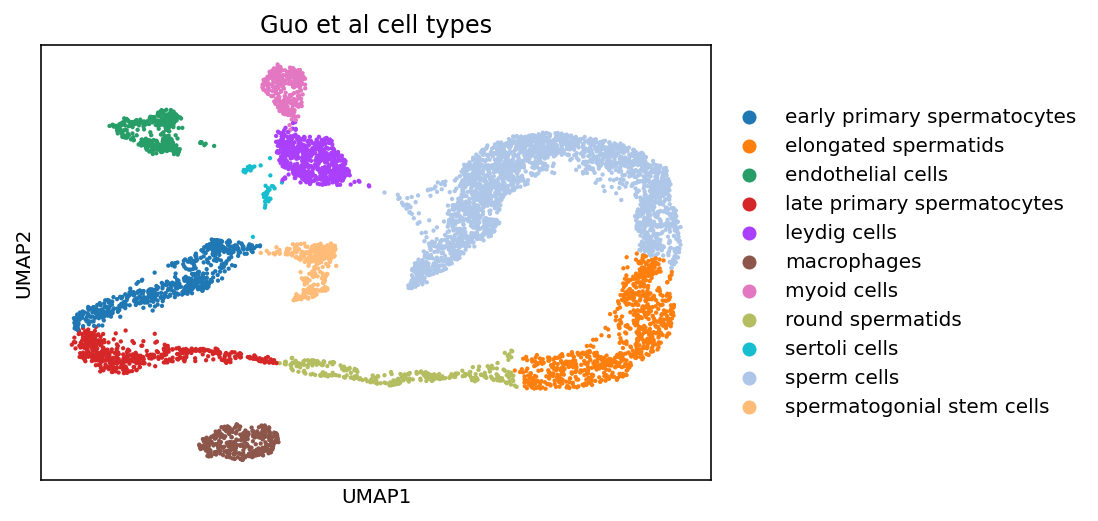

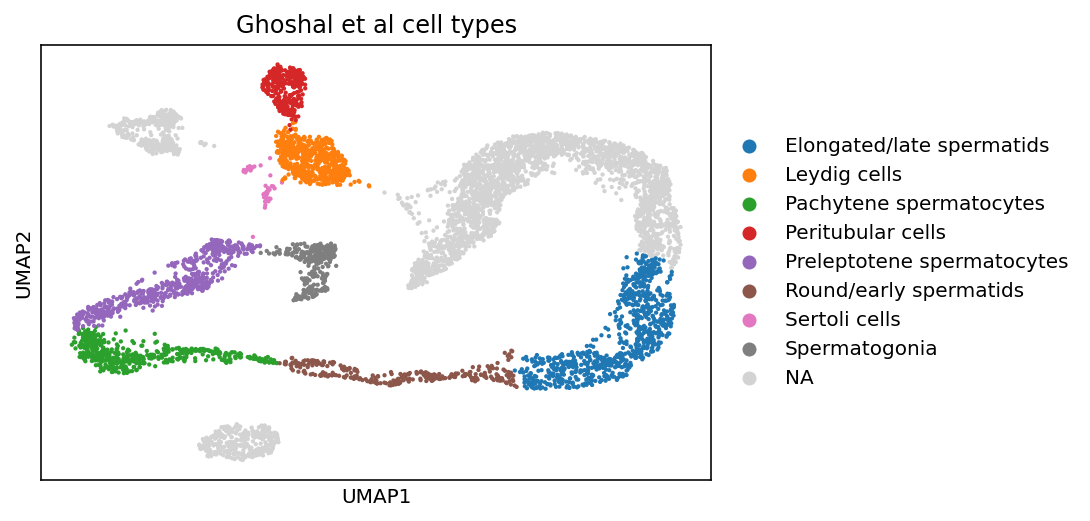

In [11]:
# correspondence between terms in Guo and terms in Ghoshal
cell_mapping = {
    'early primary spermatocytes':'Preleptotene spermatocytes',
    'elongated spermatids':'Elongated/late spermatids',
    'endothelial cells':None,
    'late primary spermatocytes':'Pachytene spermatocytes',
    'leydig cells':'Leydig cells',
    'macrophages':None,
    'myoid cells':'Peritubular cells',
    'round spermatids':'Round/early spermatids',
    'sertoli cells':'Sertoli cells',
    'sperm cells':None,
    'spermatogonial stem cells':'Spermatogonia'
}
adata.obs['Ghoshal_types'] = adata.obs['cell_type'].map(cell_mapping)
# sc.pl.umap(adata,color=['cell_type'],show=False)
# plt.savefig('./figures/testis_cell_types.png',dpi=300)
# sc.pl.umap(adata,color=['Ghoshal_types'])
# plt.savefig('./figures/testis_ghoshal_types.png',dpi=300)
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
sc.pl.umap(adata,color=['leiden'],title='Leiden clusters')
sc.pl.umap(adata,color='cell_type',title='Guo et al cell types')
sc.pl.umap(adata,color='Ghoshal_types',title='Ghoshal et al cell types')

In [8]:
gene_symbols = pd.read_csv('./data/gene_symbols.tsv',sep='\t',index_col=0).iloc[:,-1].dropna().to_dict()
adata = adata[:,adata.var_names.isin(gene_symbols)]
adata.var_names = adata.var_names.map(gene_symbols)

adata.write('./data/testis.h5')
adata

AnnData object with n_obs × n_vars = 6490 × 18361
    obs: 'Donor', 'leiden', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Donor_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
adata = adata.raw.to_adata()
adata = adata[:,adata.var_names.isin(gene_symbols)]
adata.var_names = adata.var_names.map(gene_symbols)

specificity = adata.to_df().groupby(adata.obs['cell_type']).mean().T 
specificity += 1 / adata.shape[0] # pseudocount
specificity.values[:] = specificity.values / specificity.values.sum(1,keepdims=True)

specificity.to_csv('./data/testis_rna.csv')

specificity.shape

(18361, 11)